In [1]:
# %conda install -c conda-forge cartopy

In [2]:
# Workaround to ensure lazy evaluation of xhistorams
# see https://github.com/xgcm/xhistogram/issues/12

import os
os.environ["NUMPY_EXPERIMENTAL_ARRAY_FUNCTION"] = "0"

# Heat maps

In [3]:
# parameters
dataset_version = "v2019.09.11.2"
bucket_stokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_with_stokes.zarr"
bucket_nostokes = f"pangeo-parcels/med_sea_connectivity_{dataset_version}/traj_data_without_stokes.zarr"

path_stokes = "../../medseadata/traj_data_with_stokes.zarr"
path_nostokes = "../../medseadata/traj_data_without_stokes.zarr"


species = {
    "Striped red mullet": {
        "settling_start_days": 25,
        "settling_end_days": 35,
        "min_temp": 10.0,
        "max_temp": 28.0,
        "latest_spawning_month": 7
    },
    "White seabream": {
        "settling_start_days": 26,
        "settling_end_days": 30,
        "min_temp": 10.0,
        "max_temp": 28.0,
        "latest_spawning_month": 6
    },
    "Comber": {
        "settling_start_days": 21,
        "settling_end_days": 28,
        "min_temp": 10.0,
        "max_temp": 28.0,
        "latest_spawning_month": 7
    }
}

MPA_names = {
    0: 'Ocean', 
    1: 'Cote Bleue',
    2: 'Cerbere-Banyuls',
    3: 'Cape de Creus',
    4: 'Columbretes',
    5: 'Cala Ratjada',
    6: 'Menorca',
    7: 'Tabarca',
    8: 'Cabo de Palos',
    9: 'Cabo de Gata',
    10: 'Coast'
}

n_lon_bins = 200
n_lat_bins = 200

filter_warnings = "ignore"  # No warnings will bother you.  Change for debugging.

In [4]:
import warnings
warnings.filterwarnings(filter_warnings)

## Load all modules and spin up a Dask cluster

In [5]:
from dask import config as dconf

In [6]:
# dconf.get("kubernetes.worker-template.spec.containers")

In [7]:
# dconf.set({"kubernetes.worker-template.spec.containers":
#     [{
#         'args': [
#             'dask-worker',
#             '--nthreads',
#             '6',
#             '--no-bokeh',
#             '--memory-limit',
#             '32GB',
#             '--death-timeout',
#             '60'
#         ],
#         'image': '${JUPYTER_IMAGE_SPEC}',
#         'name': 'dask-${JUPYTERHUB_USER}',
#         'resources': {'limits': {'cpu': 4, 'memory': '32G'},
#                       'requests': {'cpu': 3, 'memory': '32G'}}}]
# })

In [8]:
%matplotlib inline
import seaborn as sns
from dask import array as da
import numpy as np
import xarray as xr
# from gcsfs.mapping import GCSMap
from xhistogram.xarray import histogram as xhist
from matplotlib import pyplot as plt
import pandas as pd
from dask import delayed

In [9]:
sns.set_context("talk")
sns.set_style("darkgrid")

In [10]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
import os

cluster = SLURMCluster(
    cores=12,
    processes=1,
    memory="200GB",
    shebang='#!/usr/bin/env bash',
    queue="medium",
    walltime="00:30:00",
    local_directory='/tmp',
    death_timeout="15s",
    interface="ib0",
    log_directory=f'{os.environ["TMPDIR"]}/dask_jobqueue_logs/')

client = Client(cluster)
client

Client Scheduler: tcp://10.246.201.1:42724 Dashboard: http://10.246.201.1:37843/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [11]:
cluster.scale(12)

In [12]:
# from dask.distributed import Client, progress

# # from dask_kubernetes import KubeCluster

# # cluster = KubeCluster(n_workers=20, silence_logs=50)
# # cluster.adapt(minimum=20, maximum=100, wait_count=15)

# # client = Client(cluster, silence_logs=50)
# # client

In [13]:
# client = Client(n_workers=4, threads_per_worker=4, memory_limit=32e9)
# client

** ☝️ Don't forget to click the link above to view the scheduler dashboard! **

## Load data

All trajectories are stored in a Google Cloud Storage bucket. We want to be able to load and filter all trajectories easily.  To this end, we load all the datasets (lazily), filter them to different parameters (starting MPA, depth, stokes drift), and store a Pandas dataframe with virtual sub-datasets for each combination of the parameters.  This Pandas dataframe will be pickled for later re-use.

In [14]:
def open_dataset(path, restrict_to_MPA=None, restrict_to_z=None):
    # load data
    # gcsmap = GCSMap(bucket)
    ds = xr.open_zarr(path, decode_cf=True)
    
    # get info on starting region and make it an easy-to-look-up coord
    initial_MPA = ds.MPA.isel(obs=0).squeeze()
    ds.coords["initial_MPA"] = initial_MPA
     
    # add mask that is False after land contact
    ds["before_land_contact"] = ((ds.land == 0).cumprod("obs") == 1)
      
    return ds

In [15]:
ds_stokes = open_dataset(path_stokes)
ds_nostokes = open_dataset(path_nostokes)

## Simplify

We know a few things about our data that make it easier to deal with them:

- No vertical migration.  Hence, initial depth of a particle is valid for all times.

- All time steps are the same. Hence, we can easily build a relative time axis that is valid for all particles.

In [16]:
def apply_assumptions(ds):
    """Applies simplifications to the dataset that are valid for the 
    specific set of experiments we're dealing with here.
    
    Be careful when applying these to new experiments, because
    they might not apply.
    """
    # We assume no vertical migration and hence
    # make (non-changing) depth level an easy to look up coord
    z = ds.z.isel(obs=0).squeeze()
    ds["z"] = z
    ds.coords["z"] = ds.z
    
    # We assume that all time steps are equal
    # and that the time axis is measured in seconds
    # since some reference period
    time_axis = ds.reset_coords(["z", "initial_MPA"]).time.isel(traj=0).squeeze()
    time_axis -= time_axis.isel(obs=0).squeeze()
    time_axis.attrs["units"] = "seconds since start of particle"
    ds.coords["time_axis"] = time_axis
    
    return ds

In [17]:
ds_stokes = apply_assumptions(ds_stokes)
ds_nostokes = apply_assumptions(ds_nostokes)

## Load coordinates for quicker access

So far, we did only the bare minimum of information (data types, variable names, number of time steps, ...) but did not load any of the data.  We want to continue to do so for the bulk of the data, but get coordinates and the like now.

In [18]:
def persist_coords(ds, retries=40):
    """Will load coordinate data to the cluster."""
    ds["z"] = ds["z"].persist(retries=retries)
    ds["initial_MPA"] = ds["initial_MPA"].persist(retries=retries)
    ds["time_axis"] = ds["time_axis"].persist(retries=retries)
    return ds

In [19]:
def compute_coords(ds, retries=40):
    """Will load coordinate data to the front end."""
    ds["z"] = ds["z"].compute(retries=retries)
    ds["initial_MPA"] = ds["initial_MPA"].compute(retries=retries)
    ds["time_axis"] = ds["time_axis"].compute(retries=retries)
    return ds

In [20]:
ds_stokes = persist_coords(ds_stokes)
ds_nostokes = persist_coords(ds_nostokes)

In [21]:
ds_stokes = compute_coords(ds_stokes)
ds_nostokes = compute_coords(ds_nostokes)

In [22]:
ds_stokes

<xarray.Dataset>
Dimensions:              (obs: 962, traj: 2625480)
Coordinates:
    z                    (traj) float32 1.0182366 1.0182366 ... 1.0182366
    initial_MPA          (traj) float32 1.0 1.0 1.0 1.0 1.0 ... 9.0 9.0 9.0 9.0
    time_axis            (obs) timedelta64[ns] 00:00:00 ... 40 days 00:00:00
Dimensions without coordinates: obs, traj
Data variables:
    MPA                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    distance             (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    land                 (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    lat                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    lon                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    temp                 (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    time                 (traj, obs) datet

In [23]:
ds_nostokes

<xarray.Dataset>
Dimensions:              (obs: 962, traj: 13188600)
Coordinates:
    z                    (traj) float32 1.0182366 1.0182366 ... 10.536604
    initial_MPA          (traj) float32 1.0 1.0 1.0 1.0 1.0 ... 9.0 9.0 9.0 9.0
    time_axis            (obs) timedelta64[ns] 00:00:00 ... 40 days 00:00:00
Dimensions without coordinates: obs, traj
Data variables:
    MPA                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    distance             (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    land                 (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    lat                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    lon                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    temp                 (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    time                 (traj, obs) date

In [24]:
def get_z_values(ds):
    """Load unique z-values to the front end.
    
    This triggers a computation across all of the z-level data.
    """
    z_values = da.unique(ds.z.data).compute(retries=40)
    z_values = z_values[~np.isnan(z_values)]
    return z_values

In [25]:
z_values = get_z_values(ds_nostokes)

In [26]:
print(z_values)

[ 1.0182366  3.1657474  5.4649634  7.9203773 10.536604 ]


## Kill based on temperature

In [27]:
def apply_temp_range(ds, species_name):
    # If we're close to land, temp=0 gets linearly
    # interpolated to the particle position
    actual_temp = ds.temp / (1 - ds.land)
    
    does_not_die = (
        (actual_temp > species[species_name]["min_temp"])
        & (actual_temp < species[species_name]["max_temp"])
    )
    ds["does_not_die"] = does_not_die
    
    is_alive = (does_not_die.cumprod("obs") == 1)
    ds["is_alive"] = is_alive
    
    return ds

In [28]:
# Pick first species. We don't have varying temperature ranges (yet?).
ds_nostokes = apply_temp_range(ds_nostokes, "Striped red mullet")
ds_nostokes

<xarray.Dataset>
Dimensions:              (obs: 962, traj: 13188600)
Coordinates:
    z                    (traj) float32 1.0182366 1.0182366 ... 10.536604
    initial_MPA          (traj) float32 1.0 1.0 1.0 1.0 1.0 ... 9.0 9.0 9.0 9.0
    time_axis            (obs) timedelta64[ns] 00:00:00 ... 40 days 00:00:00
Dimensions without coordinates: obs, traj
Data variables:
    MPA                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    distance             (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    land                 (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    lat                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    lon                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    temp                 (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    time                 (traj, obs) date

In [29]:
ds_stokes = apply_temp_range(ds_stokes, "Striped red mullet")
ds_stokes

<xarray.Dataset>
Dimensions:              (obs: 962, traj: 2625480)
Coordinates:
    z                    (traj) float32 1.0182366 1.0182366 ... 1.0182366
    initial_MPA          (traj) float32 1.0 1.0 1.0 1.0 1.0 ... 9.0 9.0 9.0 9.0
    time_axis            (obs) timedelta64[ns] 00:00:00 ... 40 days 00:00:00
Dimensions without coordinates: obs, traj
Data variables:
    MPA                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    distance             (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    land                 (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    lat                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    lon                  (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    temp                 (traj, obs) float32 dask.array<chunksize=(100000, 962), meta=np.ndarray>
    time                 (traj, obs) datet

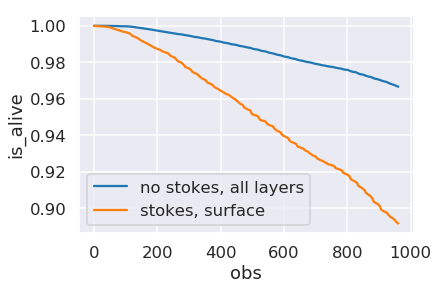

In [30]:
ds_nostokes.is_alive.astype("float").mean("traj").compute(retries=40).plot(label="no stokes, all layers")
ds_stokes.is_alive.astype("float").mean("traj").compute(retries=40).plot(label="stokes, surface");
plt.gca().legend();

In [31]:
# actually apply the temp range
ds_stokes = ds_stokes.where(ds_stokes.is_alive)
ds_nostokes = ds_nostokes.where(ds_nostokes.is_alive)

## Be able to filter for spawning month

Not all species spawn for the same time span.  "White seabream" only spawns till June.  As the physical trajectories are otherwise equivalent, we want to be able to remove those trajectories that start too late in the year:

## Be able to filter for settling period

In [32]:
def filter_settling_period(ds, species_name):
    return ds.isel(
        obs=slice(
            int(species[species_name]["settling_start_days"] * 24),
            int(species[species_name]["settling_end_days"] * 24) + 1
        )
    )

## Be able to find trajectories that _never_ touch land

In [33]:
def get_never_touches_land(ds):
    ds =  ds.where(ds.land.max("obs") == 0)
    return ds

## Heat Maps

In [34]:
def get_bnds(ds, varname):
    var_min = ds[varname].min().persist(retries=40)
    var_max = ds[varname].max().persist(retries=40)
    var_bnds = [var_min.compute(), var_max.compute()]
    return var_bnds

In [35]:
# lat_bnds_stokes = get_bnds(ds_stokes, "lat")
# lat_bnds_nostokes = get_bnds(ds_nostokes, "lat")
# lat_bnds = [
#     min(lat_bnds_stokes[0], lat_bnds_stokes[1]),
#     max(lat_bnds_stokes[0], lat_bnds_stokes[1]),
# ]

# lon_bnds_stokes = get_bnds(ds_stokes, "lon")
# lon_bnds_nostokes = get_bnds(ds_nostokes, "lon")
# lon_bnds = [
#     min(lon_bnds_stokes[0], lon_bnds_stokes[1]),
#     max(lon_bnds_stokes[0], lon_bnds_stokes[1]),
# ]

In [36]:
# print("lat_bnds", lat_bnds)
# print("lon_bnds", lon_bnds)

In [37]:
lat_bnds = [35.0, 44.0]
lon_bnds = [-6.0, 10.0]

In [38]:
lat_bins = np.linspace(lat_bnds[0], lat_bnds[1], n_lat_bins + 1)
lon_bins = np.linspace(lon_bnds[0], lon_bnds[1], n_lon_bins + 1)

In [39]:
def heat_map(ds):
    heat_map = xhist(
        ds.lat,
        ds.lon,
        bins=[lat_bins, lon_bins],
        dim=["traj", "obs"]
    )
    
    heat_map = heat_map.where(heat_map > 0)
        
    return heat_map

## Heat map stokes vs. no stokes, surface

In [40]:
heat_map_stokes_z0 = heat_map(ds_stokes)
heat_map_stokes_z0

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 200, lon_bin: 200)>
dask.array<where, shape=(200, 200), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat_bin  (lat_bin) float64 35.02 35.07 35.11 35.16 ... 43.89 43.93 43.98
  * lon_bin  (lon_bin) float64 -5.96 -5.88 -5.8 -5.72 ... 9.72 9.8 9.88 9.96

In [41]:
heat_map_nostokes_z0 = heat_map(ds_nostokes.where(ds_nostokes.z == z_values[0]))
heat_map_nostokes_z0

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 200, lon_bin: 200)>
dask.array<where, shape=(200, 200), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat_bin  (lat_bin) float64 35.02 35.07 35.11 35.16 ... 43.89 43.93 43.98
  * lon_bin  (lon_bin) float64 -5.96 -5.88 -5.8 -5.72 ... 9.72 9.8 9.88 9.96

In [42]:
heat_map_stokes_z0 = heat_map_stokes_z0.persist(retries=40)
heat_map_nostokes_z0 = heat_map_nostokes_z0.persist(retries=40)

In [43]:
import cartopy.crs as ccrs

In [44]:
def plot_two_histograms(hist1, hist2, title1, title2):

    fig = plt.figure(figsize=(32, 8))

    ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.coastlines('10m')
    # ax1.set_extent([-45, 55, 20, 80], ccrs.PlateCarree())

    gl1 = ax1.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl1.xlabels_top = False
    gl1.ylabels_right = False

    ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
    ax2.coastlines('10m')
    # ax2.set_extent([-45, 55, 20, 80], ccrs.PlateCarree())

    gl2 = ax2.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl2.xlabels_top = False
    gl2.ylabels_right = False

    xr.ufuncs.log10(hist1).plot(ax=ax1, vmin=1, vmax=6, transform=ccrs.PlateCarree(), rasterized=True)
    xr.ufuncs.log10(hist2).plot(ax=ax2, vmin=1, vmax=6, transform=ccrs.PlateCarree(), rasterized=True)

    ax1.set_title(title1)
    ax2.set_title(title2)

    # fig.tight_layout();
    
    return fig

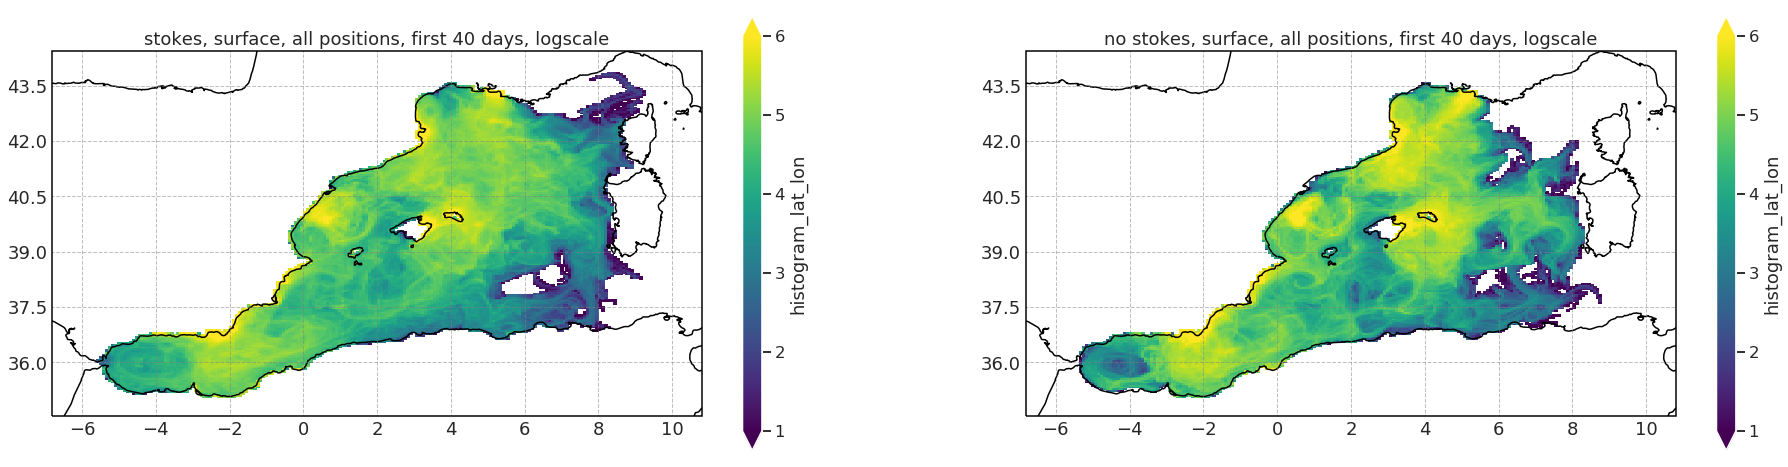

In [45]:
fig = plot_two_histograms(
    heat_map_stokes_z0.compute(retries=40),
    heat_map_nostokes_z0.compute(retries=40),
    "stokes, surface, all positions, first 40 days, logscale",
    "no stokes, surface, all positions, first 40 days, logscale"
)

In [46]:
fig.savefig("plots/heat_maps_stokes_vs_nostokes_z0.png")
fig.savefig("plots/heat_maps_stokes_vs_nostokes_z0.pdf")

In [47]:
heat_map_stokes_z0.to_dataset(
    name="heat_map_stokes_z0"
).to_netcdf(
    "output_data/heat_map_stokes_z0.nc"
);

heat_map_nostokes_z0.to_dataset(
    name="heat_map_nostokes_z0"
).to_netcdf(
    "output_data/heat_map_nostokes_z0.nc"
);


## Heat map no stokes, z min vs. z max, MPA5

In [48]:
heat_map_nostokes_z0_MPA5 = heat_map(
    ds_nostokes.where(
        (ds_nostokes.initial_MPA == 5)
        & (ds_nostokes.z == z_values[0])
    )
)
heat_map_nostokes_z0_MPA5

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 200, lon_bin: 200)>
dask.array<where, shape=(200, 200), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat_bin  (lat_bin) float64 35.02 35.07 35.11 35.16 ... 43.89 43.93 43.98
  * lon_bin  (lon_bin) float64 -5.96 -5.88 -5.8 -5.72 ... 9.72 9.8 9.88 9.96

In [49]:
heat_map_nostokes_z4_MPA5 = heat_map(
    ds_nostokes.where(
        (ds_nostokes.initial_MPA == 5)
        & (ds_nostokes.z == z_values[4])
    )
)
heat_map_nostokes_z4_MPA5

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 200, lon_bin: 200)>
dask.array<where, shape=(200, 200), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat_bin  (lat_bin) float64 35.02 35.07 35.11 35.16 ... 43.89 43.93 43.98
  * lon_bin  (lon_bin) float64 -5.96 -5.88 -5.8 -5.72 ... 9.72 9.8 9.88 9.96

In [50]:
heat_map_nostokes_z0_MPA5 = heat_map_nostokes_z0_MPA5.persist(retries=40)
heat_map_nostokes_z4_MPA5 = heat_map_nostokes_z4_MPA5.persist(retries=40)

In [51]:
heat_map_nostokes_z0_MPA5.to_dataset(
    name="heat_map_nostokes_z0_MPA5"
).to_netcdf(
    "output_data/heat_map_nostokes_z0_MPA5.nc"
);

heat_map_nostokes_z4_MPA5.to_dataset(
    name="heat_map_nostokes_z4_MPA5"
).to_netcdf(
    "output_data/heat_map_nostokes_z4_MPA5.nc"
);

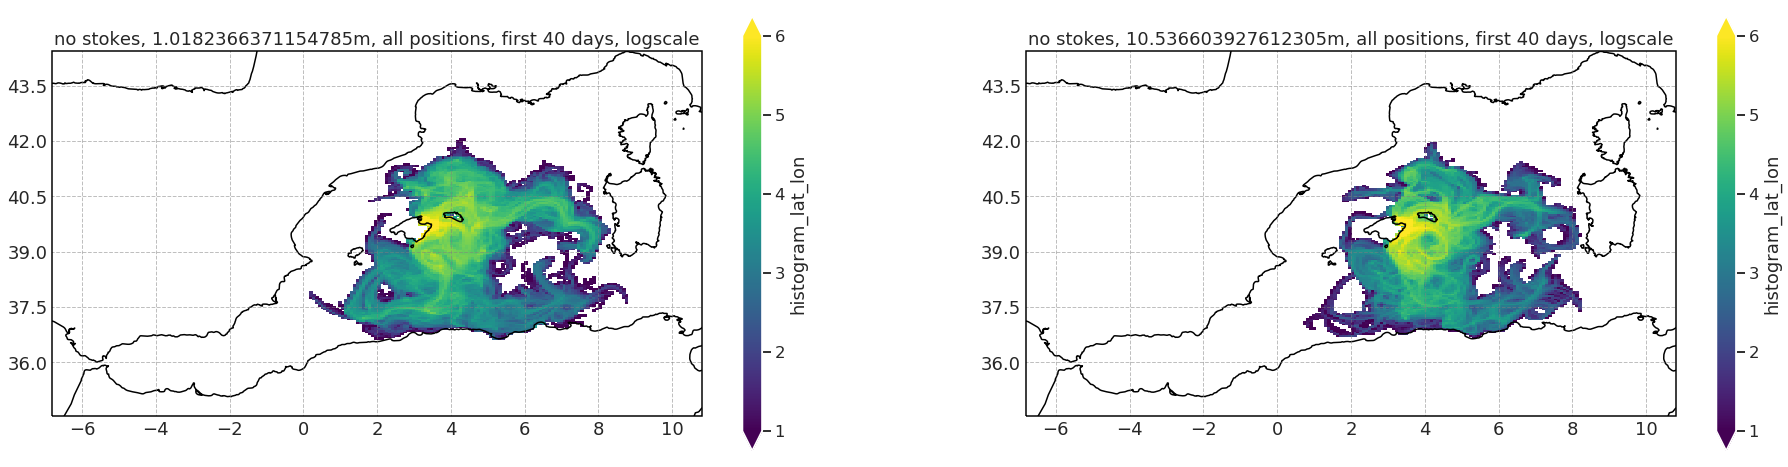

In [52]:
fig = plot_two_histograms(
    heat_map_nostokes_z0_MPA5.compute(retries=40),
    heat_map_nostokes_z4_MPA5.compute(retries=40),
    f"no stokes, {z_values[0]}m, all positions, first 40 days, logscale",
    f"no stokes, {z_values[4]}m, all positions, first 40 days, logscale"
)

In [53]:
fig.savefig("plots/heat_maps_nostokes_MPA5_z0_vs_z4.png")
fig.savefig("plots/heat_maps_nostokes_MPA5_z0_vs_z4.pdf")

## Heat map stokes noslip vs. no land contact, surface

In [54]:
heat_map_stokes_z0_no_land_contact = heat_map(get_never_touches_land(ds_stokes))
heat_map_stokes_z0_no_land_contact

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 200, lon_bin: 200)>
dask.array<where, shape=(200, 200), dtype=float64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
  * lat_bin  (lat_bin) float64 35.02 35.07 35.11 35.16 ... 43.89 43.93 43.98
  * lon_bin  (lon_bin) float64 -5.96 -5.88 -5.8 -5.72 ... 9.72 9.8 9.88 9.96

In [55]:
heat_map_stokes_z0_no_land_contact.to_dataset(
    name="heat_map_stokes_z0_no_land_contact"
).to_netcdf(
    "output_data/heat_map_stokes_z0_no_land_contact.nc"
);

In [56]:
heat_map_stokes_z0_no_land_contact = heat_map_stokes_z0_no_land_contact.persist(retries=40)

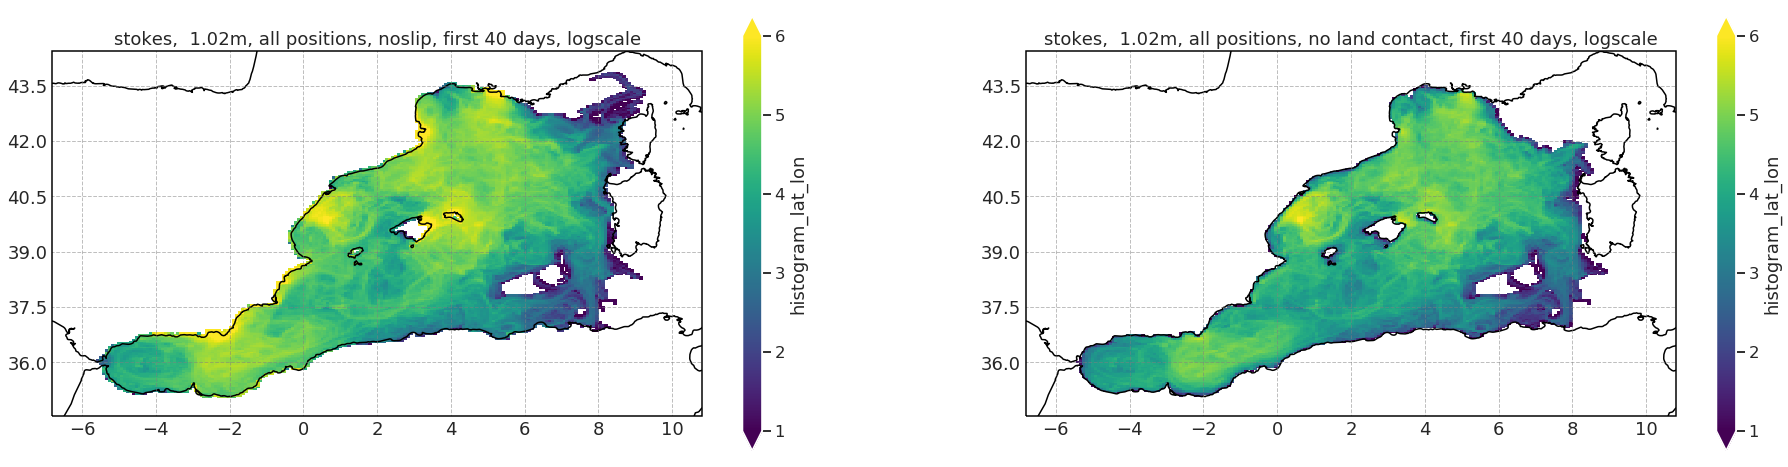

In [57]:
fig = plot_two_histograms(
    heat_map_stokes_z0.compute(retries=40),
    heat_map_stokes_z0_no_land_contact.compute(retries=40),
    f"stokes, {z_values[0]: .2f}m, all positions, noslip, first 40 days, logscale",
    f"stokes, {z_values[0]: .2f}m, all positions, no land contact, first 40 days, logscale"
)

In [58]:
fig.savefig("plots/heat_maps_stokes_z0_noslip_vs_nolandcontact.png")
fig.savefig("plots/heat_maps_stokes_z0_noslip_vs_nolandcontact.pdf")

# Technical documentation

Lists the whole working environment.

In [59]:
%pip list

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/usr/bin/sh: switchml: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_switchml'
/usr/bin/sh: _moduleraw: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC__moduleraw'
Package          Version    
---------------- -----------
asciitree        0.3.3      
asn1crypto       1.0.1      
backcall         0.1.0      
bokeh            1.3.4      
Cartopy          0.17.0     
certifi          2019.9.11  
cffi             1.12.3     
cftime           1.0.3.4    
chardet          3.0.4      
Click            7.0        
cloudpickle      1.2.2      
cmocean          2.0        
colorspacious    1.1.2      
cryptography     2.7        
cycler           0.10.0     
cytoolz          0.10.0     
dask             2.5.2      
dask-jobqueue    0.6.3 

In [60]:
%conda list --explicit

/usr/bin/sh: module: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_module'
/usr/bin/sh: switchml: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC_switchml'
/usr/bin/sh: _moduleraw: line 1: syntax error: unexpected end of file
/usr/bin/sh: error importing function definition for `BASH_FUNC__moduleraw'
# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://repo.anaconda.com/pkgs/main/linux-64/_libgcc_mutex-0.1-main.conda
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2019.9.11-hecc5488_0.tar.bz2
https://repo.anaconda.com/pkgs/main/linux-64/libgfortran-ng-7.3.0-hdf63c60_0.conda
https://repo.anaconda.com/pkgs/main/linux-64/libstdcxx-ng-9.1.0-hdf63c60_0.conda
https://repo.anaconda.com/pkgs/main/linux-64/libgcc-ng-9.1.0-hdf63c60_0.conda
https://conda.anaconda.org/co